In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM_species"
ood = "0:2:3"


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 42153 images
Dataset type val label type: species


Loaded 5269 images
Dataset type test label type: species


Loaded 5270 images
Dataset type test label type: species


Loaded 43520 images


In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

0:2:3 csroh3h4


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

trn_inp = []
trn_e_u = []
trn_e_v = []
trn_rcn = []
trn_tgt = []

val_inp = []
val_e_u = []
val_e_v = []
val_rcn = []
val_tgt = []

ind_inp = []
ind_e_u = []
ind_e_v = []
ind_rcn = []
ind_tgt = []

if ood_str:
    ood_inp = []
    ood_e_u = []
    ood_e_v = []
    ood_rcn = []
    ood_tgt = []

rnd_inp = []
rnd_e_u = []
rnd_e_v = []
rnd_rcn = []

# train set (ind)
for batch_idx, batch in enumerate(tqdm(train_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
    trn_inp.extend(x.detach().cpu().numpy())
    trn_e_u.extend(e_u.detach().cpu().numpy())
    trn_e_v.extend(e_v.detach().cpu().numpy())
    trn_rcn.extend(rcn.detach().cpu().numpy())
    trn_tgt.extend(y.detach().cpu().numpy())
print("train - OK")

# val set (ind)
for batch_idx, batch in enumerate(tqdm(val_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
    val_inp.extend(x.detach().cpu().numpy())
    val_e_u.extend(e_u.detach().cpu().numpy())
    val_e_v.extend(e_v.detach().cpu().numpy())
    val_rcn.extend(rcn.detach().cpu().numpy())
    val_tgt.extend(y.detach().cpu().numpy())
print("val - OK")

# test set (ind)
for batch_idx, batch in enumerate(tqdm(test_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
    ind_inp.extend(x.detach().cpu().numpy())
    ind_e_u.extend(e_u.detach().cpu().numpy())
    ind_e_v.extend(e_v.detach().cpu().numpy())
    ind_rcn.extend(rcn.detach().cpu().numpy())
    ind_tgt.extend(y.detach().cpu().numpy())
print("test InD - OK")

# predict set (ood)
if ood_str:
    for batch_idx, batch in enumerate(tqdm(predict_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ood_inp.extend(x.detach().cpu().numpy())
        ood_e_u.extend(e_u.detach().cpu().numpy())
        ood_e_v.extend(e_v.detach().cpu().numpy())
        ood_rcn.extend(rcn.detach().cpu().numpy())
        ood_tgt.extend(y.detach().cpu().numpy())
    print("test OoD - OK")

# random set
rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
for batch_idx, batch in enumerate(tqdm(rnd_set)):
    x = batch
    x = x.float().cuda()
    (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
    rnd_inp.extend(x.detach().cpu().numpy())
    rnd_e_u.extend(e_u.detach().cpu().numpy())
    rnd_e_v.extend(e_v.detach().cpu().numpy())
    rnd_rcn.extend(rcn.detach().cpu().numpy())
print("test RnD - OK")

  0%|                                                                                                                                             | 0/659 [00:00<?, ?it/s]

  0%|▏                                                                                                                                    | 1/659 [00:00<09:44,  1.13it/s]

  0%|▌                                                                                                                                    | 3/659 [00:00<02:57,  3.70it/s]

  1%|█                                                                                                                                    | 5/659 [00:01<01:43,  6.29it/s]

  1%|█▍                                                                                                                                   | 7/659 [00:01<01:13,  8.85it/s]

  1%|█▊                                                                                                                                   | 9/659 [00:01<00:58, 11.19it/s]

  2%|██▏                                                                                                                                 | 11/659 [00:01<00:49, 13.22it/s]

  2%|██▌                                                                                                                                 | 13/659 [00:01<00:43, 14.87it/s]

  2%|███                                                                                                                                 | 15/659 [00:01<00:39, 16.19it/s]

  3%|███▍                                                                                                                                | 17/659 [00:01<00:37, 17.20it/s]

  3%|███▊                                                                                                                                | 19/659 [00:01<00:35, 17.93it/s]

  3%|████▏                                                                                                                               | 21/659 [00:01<00:34, 18.49it/s]

  3%|████▌                                                                                                                               | 23/659 [00:02<00:33, 18.88it/s]

  4%|█████                                                                                                                               | 25/659 [00:02<00:33, 19.12it/s]

  4%|█████▍                                                                                                                              | 27/659 [00:02<00:32, 19.34it/s]

  4%|█████▊                                                                                                                              | 29/659 [00:02<00:32, 19.49it/s]

  5%|██████▏                                                                                                                             | 31/659 [00:02<00:32, 19.62it/s]

  5%|██████▌                                                                                                                             | 33/659 [00:02<00:31, 19.67it/s]

  5%|███████                                                                                                                             | 35/659 [00:02<00:31, 19.73it/s]

  6%|███████▍                                                                                                                            | 37/659 [00:02<00:31, 19.77it/s]

  6%|███████▊                                                                                                                            | 39/659 [00:02<00:31, 19.80it/s]

  6%|████████▏                                                                                                                           | 41/659 [00:02<00:31, 19.81it/s]

  7%|████████▌                                                                                                                           | 43/659 [00:03<00:31, 19.83it/s]

  7%|█████████                                                                                                                           | 45/659 [00:03<00:30, 19.85it/s]

  7%|█████████▍                                                                                                                          | 47/659 [00:03<00:30, 19.82it/s]

  7%|█████████▊                                                                                                                          | 49/659 [00:03<00:30, 19.84it/s]

  8%|██████████▏                                                                                                                         | 51/659 [00:03<00:30, 19.85it/s]

  8%|██████████▌                                                                                                                         | 53/659 [00:03<00:30, 19.86it/s]

  8%|███████████                                                                                                                         | 55/659 [00:03<00:30, 19.84it/s]

  9%|███████████▍                                                                                                                        | 57/659 [00:03<00:30, 19.85it/s]

  9%|███████████▊                                                                                                                        | 59/659 [00:03<00:30, 19.86it/s]

  9%|████████████▏                                                                                                                       | 61/659 [00:03<00:30, 19.85it/s]

 10%|████████████▌                                                                                                                       | 63/659 [00:04<00:30, 19.86it/s]

 10%|█████████████                                                                                                                       | 65/659 [00:04<00:29, 19.87it/s]

 10%|█████████████▍                                                                                                                      | 67/659 [00:04<00:29, 19.86it/s]

 10%|█████████████▊                                                                                                                      | 69/659 [00:04<00:29, 19.84it/s]

 11%|██████████████▏                                                                                                                     | 71/659 [00:04<00:29, 19.86it/s]

 11%|██████████████▌                                                                                                                     | 73/659 [00:04<00:29, 19.86it/s]

 11%|███████████████                                                                                                                     | 75/659 [00:04<00:29, 19.84it/s]

 12%|███████████████▍                                                                                                                    | 77/659 [00:04<00:29, 19.85it/s]

 12%|███████████████▊                                                                                                                    | 79/659 [00:04<00:29, 19.86it/s]

 12%|████████████████▏                                                                                                                   | 81/659 [00:04<00:29, 19.86it/s]

 13%|████████████████▋                                                                                                                   | 83/659 [00:05<00:29, 19.85it/s]

 13%|█████████████████                                                                                                                   | 85/659 [00:05<00:28, 19.86it/s]

 13%|█████████████████▍                                                                                                                  | 87/659 [00:05<00:28, 19.86it/s]

 14%|█████████████████▊                                                                                                                  | 89/659 [00:05<00:28, 19.85it/s]

 14%|██████████████████▏                                                                                                                 | 91/659 [00:05<00:28, 19.85it/s]

 14%|██████████████████▋                                                                                                                 | 93/659 [00:05<00:28, 19.86it/s]

 14%|███████████████████                                                                                                                 | 95/659 [00:05<00:28, 19.86it/s]

 15%|███████████████████▍                                                                                                                | 97/659 [00:05<00:28, 19.83it/s]

 15%|███████████████████▊                                                                                                                | 99/659 [00:05<00:28, 19.84it/s]

 15%|████████████████████                                                                                                               | 101/659 [00:05<00:28, 19.85it/s]

 16%|████████████████████▍                                                                                                              | 103/659 [00:06<00:28, 19.82it/s]

 16%|████████████████████▊                                                                                                              | 105/659 [00:06<00:27, 19.84it/s]

 16%|█████████████████████▎                                                                                                             | 107/659 [00:06<00:27, 19.85it/s]

 17%|█████████████████████▋                                                                                                             | 109/659 [00:06<00:27, 19.85it/s]

 17%|██████████████████████                                                                                                             | 111/659 [00:06<00:27, 19.84it/s]

 17%|██████████████████████▍                                                                                                            | 113/659 [00:06<00:27, 19.84it/s]

 17%|██████████████████████▊                                                                                                            | 115/659 [00:06<00:27, 19.85it/s]

 18%|███████████████████████▎                                                                                                           | 117/659 [00:06<00:27, 19.83it/s]

 18%|███████████████████████▋                                                                                                           | 119/659 [00:06<00:27, 19.83it/s]

 18%|████████████████████████                                                                                                           | 121/659 [00:06<00:27, 19.81it/s]

 19%|████████████████████████▍                                                                                                          | 123/659 [00:07<00:27, 19.83it/s]

 19%|████████████████████████▊                                                                                                          | 125/659 [00:07<00:26, 19.81it/s]

 19%|█████████████████████████▏                                                                                                         | 127/659 [00:07<00:26, 19.83it/s]

 20%|█████████████████████████▋                                                                                                         | 129/659 [00:07<00:26, 19.83it/s]

 20%|██████████████████████████                                                                                                         | 131/659 [00:07<00:26, 19.81it/s]

 20%|██████████████████████████▍                                                                                                        | 133/659 [00:07<00:26, 19.81it/s]

 20%|██████████████████████████▊                                                                                                        | 135/659 [00:07<00:26, 19.82it/s]

 21%|███████████████████████████▏                                                                                                       | 137/659 [00:07<00:26, 19.82it/s]

 21%|███████████████████████████▋                                                                                                       | 139/659 [00:07<00:26, 19.80it/s]

 21%|████████████████████████████                                                                                                       | 141/659 [00:07<00:26, 19.81it/s]

 22%|████████████████████████████▍                                                                                                      | 143/659 [00:08<00:26, 19.82it/s]

 22%|████████████████████████████▊                                                                                                      | 145/659 [00:08<00:25, 19.81it/s]

 22%|█████████████████████████████▏                                                                                                     | 147/659 [00:08<00:25, 19.82it/s]

 23%|█████████████████████████████▌                                                                                                     | 149/659 [00:08<00:25, 19.81it/s]

 23%|██████████████████████████████                                                                                                     | 151/659 [00:08<00:25, 19.81it/s]

 23%|██████████████████████████████▍                                                                                                    | 153/659 [00:08<00:25, 19.79it/s]

 24%|██████████████████████████████▊                                                                                                    | 155/659 [00:08<00:25, 19.80it/s]

 24%|███████████████████████████████▏                                                                                                   | 157/659 [00:08<00:25, 19.80it/s]

 24%|███████████████████████████████▌                                                                                                   | 159/659 [00:08<00:25, 19.80it/s]

 24%|████████████████████████████████                                                                                                   | 161/659 [00:08<00:25, 19.81it/s]

 25%|████████████████████████████████▍                                                                                                  | 163/659 [00:09<00:25, 19.82it/s]

 25%|████████████████████████████████▊                                                                                                  | 165/659 [00:09<00:24, 19.82it/s]

 25%|█████████████████████████████████▏                                                                                                 | 167/659 [00:09<00:24, 19.81it/s]

 26%|█████████████████████████████████▌                                                                                                 | 169/659 [00:09<00:24, 19.73it/s]

 26%|█████████████████████████████████▉                                                                                                 | 171/659 [00:09<00:24, 19.75it/s]

 26%|██████████████████████████████████▍                                                                                                | 173/659 [00:09<00:24, 19.75it/s]

 27%|██████████████████████████████████▊                                                                                                | 175/659 [00:09<00:24, 19.77it/s]

 27%|███████████████████████████████████▏                                                                                               | 177/659 [00:09<00:24, 19.77it/s]

 27%|███████████████████████████████████▌                                                                                               | 179/659 [00:09<00:24, 19.78it/s]

 27%|███████████████████████████████████▉                                                                                               | 181/659 [00:09<00:24, 19.76it/s]

 28%|████████████████████████████████████▍                                                                                              | 183/659 [00:10<00:24, 19.79it/s]

 28%|████████████████████████████████████▊                                                                                              | 185/659 [00:10<00:23, 19.78it/s]

 28%|█████████████████████████████████████▏                                                                                             | 187/659 [00:10<00:23, 19.77it/s]

 29%|█████████████████████████████████████▌                                                                                             | 189/659 [00:10<00:23, 19.78it/s]

 29%|█████████████████████████████████████▉                                                                                             | 191/659 [00:10<00:23, 19.73it/s]

 29%|██████████████████████████████████████▎                                                                                            | 193/659 [00:10<00:23, 19.72it/s]

 30%|██████████████████████████████████████▊                                                                                            | 195/659 [00:10<00:23, 19.72it/s]

 30%|███████████████████████████████████████▏                                                                                           | 197/659 [00:10<00:23, 19.73it/s]

 30%|███████████████████████████████████████▌                                                                                           | 199/659 [00:10<00:23, 19.75it/s]

 31%|███████████████████████████████████████▉                                                                                           | 201/659 [00:10<00:23, 19.74it/s]

 31%|████████████████████████████████████████▎                                                                                          | 203/659 [00:11<00:23, 19.76it/s]

 31%|████████████████████████████████████████▊                                                                                          | 205/659 [00:11<00:22, 19.77it/s]

 31%|█████████████████████████████████████████▏                                                                                         | 207/659 [00:11<00:22, 19.78it/s]

 32%|█████████████████████████████████████████▌                                                                                         | 209/659 [00:11<00:22, 19.77it/s]

 32%|█████████████████████████████████████████▉                                                                                         | 211/659 [00:11<00:22, 19.77it/s]

 32%|██████████████████████████████████████████▎                                                                                        | 213/659 [00:11<00:22, 19.78it/s]

 33%|██████████████████████████████████████████▋                                                                                        | 215/659 [00:11<00:22, 19.76it/s]

 33%|███████████████████████████████████████████▏                                                                                       | 217/659 [00:11<00:22, 19.74it/s]

 33%|███████████████████████████████████████████▌                                                                                       | 219/659 [00:11<00:22, 19.75it/s]

 34%|███████████████████████████████████████████▉                                                                                       | 221/659 [00:12<00:22, 19.77it/s]

 34%|████████████████████████████████████████████▎                                                                                      | 223/659 [00:12<00:22, 19.75it/s]

 34%|████████████████████████████████████████████▋                                                                                      | 225/659 [00:12<00:21, 19.75it/s]

 34%|█████████████████████████████████████████████                                                                                      | 227/659 [00:12<00:21, 19.77it/s]

 35%|█████████████████████████████████████████████▌                                                                                     | 229/659 [00:12<00:21, 19.76it/s]

 35%|█████████████████████████████████████████████▉                                                                                     | 231/659 [00:12<00:21, 19.77it/s]

 35%|██████████████████████████████████████████████▎                                                                                    | 233/659 [00:12<00:21, 19.76it/s]

 36%|██████████████████████████████████████████████▋                                                                                    | 235/659 [00:12<00:21, 19.75it/s]

 36%|███████████████████████████████████████████████                                                                                    | 237/659 [00:12<00:21, 19.74it/s]

 36%|███████████████████████████████████████████████▌                                                                                   | 239/659 [00:12<00:21, 19.75it/s]

 37%|███████████████████████████████████████████████▉                                                                                   | 241/659 [00:13<00:21, 19.69it/s]

 37%|████████████████████████████████████████████████▎                                                                                  | 243/659 [00:13<00:21, 19.70it/s]

 37%|████████████████████████████████████████████████▋                                                                                  | 245/659 [00:13<00:20, 19.73it/s]

 37%|█████████████████████████████████████████████████                                                                                  | 247/659 [00:13<00:20, 19.75it/s]

 38%|█████████████████████████████████████████████████▍                                                                                 | 249/659 [00:13<00:20, 19.73it/s]

 38%|█████████████████████████████████████████████████▉                                                                                 | 251/659 [00:13<00:20, 19.75it/s]

 38%|██████████████████████████████████████████████████▎                                                                                | 253/659 [00:13<00:20, 19.74it/s]

 39%|██████████████████████████████████████████████████▋                                                                                | 255/659 [00:13<00:20, 19.76it/s]

 39%|███████████████████████████████████████████████████                                                                                | 257/659 [00:13<00:20, 19.77it/s]

 39%|███████████████████████████████████████████████████▍                                                                               | 259/659 [00:13<00:20, 19.76it/s]

 40%|███████████████████████████████████████████████████▉                                                                               | 261/659 [00:14<00:20, 19.77it/s]

 40%|████████████████████████████████████████████████████▎                                                                              | 263/659 [00:14<00:20, 19.78it/s]

 40%|████████████████████████████████████████████████████▋                                                                              | 265/659 [00:14<00:19, 19.72it/s]

 41%|█████████████████████████████████████████████████████                                                                              | 267/659 [00:14<00:19, 19.71it/s]

 41%|█████████████████████████████████████████████████████▍                                                                             | 269/659 [00:14<00:19, 19.74it/s]

 41%|█████████████████████████████████████████████████████▊                                                                             | 271/659 [00:14<00:19, 19.75it/s]

 41%|██████████████████████████████████████████████████████▎                                                                            | 273/659 [00:14<00:19, 19.74it/s]

 42%|██████████████████████████████████████████████████████▋                                                                            | 275/659 [00:14<00:19, 19.75it/s]

 42%|███████████████████████████████████████████████████████                                                                            | 277/659 [00:14<00:19, 19.76it/s]

 42%|███████████████████████████████████████████████████████▍                                                                           | 279/659 [00:14<00:19, 19.76it/s]

 43%|███████████████████████████████████████████████████████▊                                                                           | 281/659 [00:15<00:19, 19.74it/s]

 43%|████████████████████████████████████████████████████████▎                                                                          | 283/659 [00:15<00:19, 19.75it/s]

 43%|████████████████████████████████████████████████████████▋                                                                          | 285/659 [00:15<00:18, 19.76it/s]

 44%|█████████████████████████████████████████████████████████                                                                          | 287/659 [00:15<00:18, 19.75it/s]

 44%|█████████████████████████████████████████████████████████▍                                                                         | 289/659 [00:15<00:18, 19.71it/s]

 44%|█████████████████████████████████████████████████████████▊                                                                         | 291/659 [00:15<00:18, 19.72it/s]

 44%|██████████████████████████████████████████████████████████▏                                                                        | 293/659 [00:15<00:18, 19.71it/s]

 45%|██████████████████████████████████████████████████████████▋                                                                        | 295/659 [00:15<00:18, 19.72it/s]

 45%|███████████████████████████████████████████████████████████                                                                        | 297/659 [00:15<00:18, 19.73it/s]

 45%|███████████████████████████████████████████████████████████▍                                                                       | 299/659 [00:15<00:18, 19.74it/s]

 46%|███████████████████████████████████████████████████████████▊                                                                       | 301/659 [00:16<00:18, 19.73it/s]

 46%|████████████████████████████████████████████████████████████▏                                                                      | 303/659 [00:16<00:18, 19.74it/s]

 46%|████████████████████████████████████████████████████████████▋                                                                      | 305/659 [00:16<00:17, 19.75it/s]

 47%|█████████████████████████████████████████████████████████████                                                                      | 307/659 [00:16<00:17, 19.74it/s]

 47%|█████████████████████████████████████████████████████████████▍                                                                     | 309/659 [00:16<00:17, 19.75it/s]

 47%|█████████████████████████████████████████████████████████████▊                                                                     | 311/659 [00:16<00:17, 19.75it/s]

 47%|██████████████████████████████████████████████████████████████▏                                                                    | 313/659 [00:16<00:17, 19.75it/s]

 48%|██████████████████████████████████████████████████████████████▌                                                                    | 315/659 [00:16<00:17, 19.59it/s]

 48%|███████████████████████████████████████████████████████████████                                                                    | 317/659 [00:16<00:17, 19.63it/s]

 48%|███████████████████████████████████████████████████████████████▍                                                                   | 319/659 [00:16<00:17, 19.67it/s]

 49%|███████████████████████████████████████████████████████████████▊                                                                   | 321/659 [00:17<00:17, 19.68it/s]

 49%|████████████████████████████████████████████████████████████████▏                                                                  | 323/659 [00:17<00:17, 19.71it/s]

 49%|████████████████████████████████████████████████████████████████▌                                                                  | 325/659 [00:17<00:16, 19.71it/s]

 50%|█████████████████████████████████████████████████████████████████                                                                  | 327/659 [00:17<00:16, 19.73it/s]

 50%|█████████████████████████████████████████████████████████████████▍                                                                 | 329/659 [00:17<00:16, 19.71it/s]

 50%|█████████████████████████████████████████████████████████████████▊                                                                 | 331/659 [00:17<00:16, 19.73it/s]

 51%|██████████████████████████████████████████████████████████████████▏                                                                | 333/659 [00:17<00:16, 19.74it/s]

 51%|██████████████████████████████████████████████████████████████████▌                                                                | 335/659 [00:17<00:16, 19.73it/s]

 51%|██████████████████████████████████████████████████████████████████▉                                                                | 337/659 [00:17<00:16, 19.74it/s]

 51%|███████████████████████████████████████████████████████████████████▍                                                               | 339/659 [00:17<00:16, 19.61it/s]

 52%|███████████████████████████████████████████████████████████████████▊                                                               | 341/659 [00:18<00:16, 19.65it/s]

 52%|████████████████████████████████████████████████████████████████████▏                                                              | 343/659 [00:18<00:16, 19.66it/s]

 52%|████████████████████████████████████████████████████████████████████▌                                                              | 345/659 [00:18<00:15, 19.68it/s]

 53%|████████████████████████████████████████████████████████████████████▉                                                              | 347/659 [00:18<00:15, 19.70it/s]

 53%|█████████████████████████████████████████████████████████████████████▍                                                             | 349/659 [00:18<00:15, 19.70it/s]

 53%|█████████████████████████████████████████████████████████████████████▊                                                             | 351/659 [00:18<00:15, 19.72it/s]

 54%|██████████████████████████████████████████████████████████████████████▏                                                            | 353/659 [00:18<00:15, 19.73it/s]

 54%|██████████████████████████████████████████████████████████████████████▌                                                            | 355/659 [00:18<00:15, 19.73it/s]

 54%|██████████████████████████████████████████████████████████████████████▉                                                            | 357/659 [00:18<00:15, 19.69it/s]

 54%|███████████████████████████████████████████████████████████████████████▎                                                           | 359/659 [00:18<00:15, 19.71it/s]

 55%|███████████████████████████████████████████████████████████████████████▊                                                           | 361/659 [00:19<00:15, 19.72it/s]

 55%|████████████████████████████████████████████████████████████████████████▏                                                          | 363/659 [00:19<00:15, 19.71it/s]

 55%|████████████████████████████████████████████████████████████████████████▌                                                          | 365/659 [00:19<00:14, 19.66it/s]

 56%|████████████████████████████████████████████████████████████████████████▉                                                          | 367/659 [00:19<00:14, 19.68it/s]

 56%|█████████████████████████████████████████████████████████████████████████▎                                                         | 369/659 [00:19<00:14, 19.67it/s]

 56%|█████████████████████████████████████████████████████████████████████████▋                                                         | 371/659 [00:19<00:14, 19.69it/s]

 57%|██████████████████████████████████████████████████████████████████████████▏                                                        | 373/659 [00:19<00:14, 19.71it/s]

 57%|██████████████████████████████████████████████████████████████████████████▌                                                        | 375/659 [00:19<00:14, 19.73it/s]

 57%|██████████████████████████████████████████████████████████████████████████▉                                                        | 377/659 [00:19<00:14, 19.71it/s]

 58%|███████████████████████████████████████████████████████████████████████████▎                                                       | 379/659 [00:20<00:14, 19.72it/s]

 58%|███████████████████████████████████████████████████████████████████████████▋                                                       | 381/659 [00:20<00:14, 19.74it/s]

 58%|████████████████████████████████████████████████████████████████████████████▏                                                      | 383/659 [00:20<00:13, 19.73it/s]

 58%|████████████████████████████████████████████████████████████████████████████▌                                                      | 385/659 [00:20<00:13, 19.73it/s]

 59%|████████████████████████████████████████████████████████████████████████████▉                                                      | 387/659 [00:20<00:13, 19.74it/s]

 59%|█████████████████████████████████████████████████████████████████████████████▎                                                     | 389/659 [00:20<00:13, 19.74it/s]

 59%|█████████████████████████████████████████████████████████████████████████████▋                                                     | 391/659 [00:20<00:13, 19.72it/s]

 60%|██████████████████████████████████████████████████████████████████████████████                                                     | 393/659 [00:20<00:13, 19.73it/s]

 60%|██████████████████████████████████████████████████████████████████████████████▌                                                    | 395/659 [00:20<00:13, 19.72it/s]

 60%|██████████████████████████████████████████████████████████████████████████████▉                                                    | 397/659 [00:20<00:13, 19.70it/s]

 61%|███████████████████████████████████████████████████████████████████████████████▎                                                   | 399/659 [00:21<00:13, 19.71it/s]

 61%|███████████████████████████████████████████████████████████████████████████████▋                                                   | 401/659 [00:21<00:13, 19.72it/s]

 61%|████████████████████████████████████████████████████████████████████████████████                                                   | 403/659 [00:21<00:13, 19.69it/s]

 61%|████████████████████████████████████████████████████████████████████████████████▌                                                  | 405/659 [00:21<00:12, 19.69it/s]

 62%|████████████████████████████████████████████████████████████████████████████████▉                                                  | 407/659 [00:21<00:12, 19.70it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████▎                                                 | 409/659 [00:21<00:12, 19.71it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████▋                                                 | 411/659 [00:21<00:12, 19.70it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████                                                 | 413/659 [00:21<00:12, 19.71it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████▍                                                | 415/659 [00:21<00:12, 19.71it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████▉                                                | 417/659 [00:21<00:12, 19.69it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████▎                                               | 419/659 [00:22<00:12, 19.70it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████▋                                               | 421/659 [00:22<00:12, 19.71it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████                                               | 423/659 [00:22<00:11, 19.73it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████▍                                              | 425/659 [00:22<00:11, 19.70it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████▉                                              | 427/659 [00:22<00:11, 19.71it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████▎                                             | 429/659 [00:22<00:11, 19.71it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████▋                                             | 431/659 [00:22<00:11, 19.69it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████                                             | 433/659 [00:22<00:11, 19.70it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████▍                                            | 435/659 [00:22<00:11, 19.70it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████▊                                            | 437/659 [00:22<00:11, 19.71it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████▎                                           | 439/659 [00:23<00:11, 19.70it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████▋                                           | 441/659 [00:23<00:11, 19.71it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████                                           | 443/659 [00:23<00:10, 19.72it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████▍                                          | 445/659 [00:23<00:10, 19.69it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████▊                                          | 447/659 [00:23<00:10, 19.71it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████▎                                         | 449/659 [00:23<00:10, 19.71it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████▋                                         | 451/659 [00:23<00:10, 19.71it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████                                         | 453/659 [00:23<00:10, 19.67it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████▍                                        | 455/659 [00:23<00:10, 19.68it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████▊                                        | 457/659 [00:23<00:10, 19.70it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████▏                                       | 459/659 [00:24<00:10, 19.68it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████▋                                       | 461/659 [00:24<00:10, 19.70it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████                                       | 463/659 [00:24<00:09, 19.71it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 465/659 [00:24<00:09, 19.69it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 467/659 [00:24<00:09, 19.69it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 469/659 [00:24<00:09, 19.70it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 471/659 [00:24<00:09, 19.70it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████                                     | 473/659 [00:24<00:09, 19.69it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 475/659 [00:24<00:09, 19.69it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 477/659 [00:24<00:09, 19.70it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 479/659 [00:25<00:09, 19.55it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 481/659 [00:25<00:09, 19.60it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████                                   | 483/659 [00:25<00:08, 19.64it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 485/659 [00:25<00:08, 19.66it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 487/659 [00:25<00:08, 19.65it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 489/659 [00:25<00:08, 19.66it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 491/659 [00:25<00:08, 19.68it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████                                 | 493/659 [00:25<00:08, 19.67it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 495/659 [00:25<00:08, 19.68it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 497/659 [00:26<00:08, 19.68it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 499/659 [00:26<00:08, 19.69it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 501/659 [00:26<00:08, 19.68it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 503/659 [00:26<00:07, 19.69it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 505/659 [00:26<00:07, 19.70it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 507/659 [00:26<00:07, 19.68it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 509/659 [00:26<00:07, 19.66it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 511/659 [00:26<00:07, 19.64it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 513/659 [00:26<00:07, 19.65it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 515/659 [00:26<00:07, 19.66it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 517/659 [00:27<00:07, 19.67it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 519/659 [00:27<00:07, 19.68it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 521/659 [00:27<00:07, 19.68it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 523/659 [00:27<00:06, 19.69it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 525/659 [00:27<00:06, 19.70it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 527/659 [00:27<00:06, 19.69it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 529/659 [00:27<00:06, 19.70it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 531/659 [00:27<00:06, 19.71it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 533/659 [00:27<00:06, 19.72it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 535/659 [00:27<00:06, 19.70it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 537/659 [00:28<00:06, 19.70it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 539/659 [00:28<00:06, 19.70it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 541/659 [00:28<00:05, 19.68it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 543/659 [00:28<00:05, 19.69it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 545/659 [00:28<00:05, 19.70it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 547/659 [00:28<00:05, 19.69it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 549/659 [00:28<00:05, 19.68it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 551/659 [00:28<00:05, 19.68it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 553/659 [00:28<00:05, 19.68it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 555/659 [00:28<00:05, 19.67it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 557/659 [00:29<00:05, 19.68it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 559/659 [00:29<00:05, 19.69it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 561/659 [00:29<00:04, 19.69it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 563/659 [00:29<00:04, 19.67it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 565/659 [00:29<00:04, 19.65it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 567/659 [00:29<00:04, 19.67it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 569/659 [00:29<00:04, 19.66it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 571/659 [00:29<00:04, 19.67it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 573/659 [00:29<00:04, 19.67it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 575/659 [00:29<00:04, 19.66it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 577/659 [00:30<00:04, 19.66it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 579/659 [00:30<00:04, 19.67it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 581/659 [00:30<00:03, 19.65it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 583/659 [00:30<00:03, 19.67it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 585/659 [00:30<00:03, 19.69it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 587/659 [00:30<00:03, 19.70it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 589/659 [00:30<00:03, 19.68it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 591/659 [00:30<00:03, 19.69it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 593/659 [00:30<00:03, 19.70it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 595/659 [00:30<00:03, 19.67it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 597/659 [00:31<00:03, 19.68it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 599/659 [00:31<00:03, 19.69it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 601/659 [00:31<00:02, 19.70it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 603/659 [00:31<00:02, 19.68it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 605/659 [00:31<00:02, 19.69it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 607/659 [00:31<00:02, 19.70it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 609/659 [00:31<00:02, 19.68it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 611/659 [00:31<00:02, 19.70it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 613/659 [00:31<00:02, 19.70it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 615/659 [00:32<00:02, 19.71it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 617/659 [00:32<00:02, 19.69it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 619/659 [00:32<00:02, 19.69it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 621/659 [00:32<00:01, 19.69it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 623/659 [00:32<00:01, 19.64it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 625/659 [00:32<00:01, 19.65it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 627/659 [00:32<00:01, 19.67it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 629/659 [00:32<00:01, 19.68it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 631/659 [00:32<00:01, 19.67it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 633/659 [00:32<00:01, 19.68it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 635/659 [00:33<00:01, 19.69it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 637/659 [00:33<00:01, 19.67it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 639/659 [00:33<00:01, 19.68it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 641/659 [00:33<00:00, 19.69it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 643/659 [00:33<00:00, 19.69it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 645/659 [00:33<00:00, 19.68it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 647/659 [00:33<00:00, 19.66it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 649/659 [00:33<00:00, 19.68it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 651/659 [00:33<00:00, 19.57it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 653/659 [00:33<00:00, 19.60it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 655/659 [00:34<00:00, 19.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 657/659 [00:34<00:00, 19.62it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 659/659 [00:34<00:00, 18.57it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 659/659 [00:34<00:00, 19.23it/s]

train - OK


  0%|                                                                                                                                              | 0/83 [00:00<?, ?it/s]

  1%|█▌                                                                                                                                    | 1/83 [00:00<00:16,  5.03it/s]

  4%|████▊                                                                                                                                 | 3/83 [00:00<00:07, 11.12it/s]

  6%|████████                                                                                                                              | 5/83 [00:00<00:05, 14.31it/s]

  8%|███████████▎                                                                                                                          | 7/83 [00:00<00:04, 16.15it/s]

 11%|██████████████▌                                                                                                                       | 9/83 [00:00<00:04, 17.32it/s]

 13%|█████████████████▋                                                                                                                   | 11/83 [00:00<00:03, 18.07it/s]

 16%|████████████████████▊                                                                                                                | 13/83 [00:00<00:03, 18.54it/s]

 18%|████████████████████████                                                                                                             | 15/83 [00:00<00:03, 18.88it/s]

 20%|███████████████████████████▏                                                                                                         | 17/83 [00:01<00:03, 19.10it/s]

 23%|██████████████████████████████▍                                                                                                      | 19/83 [00:01<00:03, 19.27it/s]

 25%|█████████████████████████████████▋                                                                                                   | 21/83 [00:01<00:03, 19.37it/s]

 28%|████████████████████████████████████▊                                                                                                | 23/83 [00:01<00:03, 19.45it/s]

 30%|████████████████████████████████████████                                                                                             | 25/83 [00:01<00:02, 19.50it/s]

 33%|███████████████████████████████████████████▎                                                                                         | 27/83 [00:01<00:02, 19.53it/s]

 35%|██████████████████████████████████████████████▍                                                                                      | 29/83 [00:01<00:02, 19.56it/s]

 37%|█████████████████████████████████████████████████▋                                                                                   | 31/83 [00:01<00:02, 19.59it/s]

 40%|████████████████████████████████████████████████████▉                                                                                | 33/83 [00:01<00:02, 19.61it/s]

 42%|████████████████████████████████████████████████████████                                                                             | 35/83 [00:01<00:02, 19.61it/s]

 45%|███████████████████████████████████████████████████████████▎                                                                         | 37/83 [00:02<00:02, 19.63it/s]

 47%|██████████████████████████████████████████████████████████████▍                                                                      | 39/83 [00:02<00:02, 19.62it/s]

 49%|█████████████████████████████████████████████████████████████████▋                                                                   | 41/83 [00:02<00:02, 19.60it/s]

 52%|████████████████████████████████████████████████████████████████████▉                                                                | 43/83 [00:02<00:02, 19.62it/s]

 54%|████████████████████████████████████████████████████████████████████████                                                             | 45/83 [00:02<00:01, 19.64it/s]

 57%|███████████████████████████████████████████████████████████████████████████▎                                                         | 47/83 [00:02<00:01, 19.61it/s]

 59%|██████████████████████████████████████████████████████████████████████████████▌                                                      | 49/83 [00:02<00:01, 19.58it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████▋                                                   | 51/83 [00:02<00:01, 19.60it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████▉                                                | 53/83 [00:02<00:01, 19.62it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████▏                                            | 55/83 [00:02<00:01, 19.60it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████▎                                         | 57/83 [00:03<00:01, 19.62it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 59/83 [00:03<00:01, 19.64it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 61/83 [00:03<00:01, 19.64it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 63/83 [00:03<00:01, 19.63it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 65/83 [00:03<00:00, 19.63it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 67/83 [00:03<00:00, 19.64it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 69/83 [00:03<00:00, 19.63it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 71/83 [00:03<00:00, 19.64it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 73/83 [00:03<00:00, 19.66it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 75/83 [00:03<00:00, 19.56it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 77/83 [00:04<00:00, 19.58it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 79/83 [00:04<00:00, 19.62it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 81/83 [00:04<00:00, 19.65it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:04<00:00, 19.02it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:04<00:00, 18.68it/s]

val - OK


  0%|                                                                                                                                              | 0/83 [00:00<?, ?it/s]

  1%|█▌                                                                                                                                    | 1/83 [00:00<00:16,  4.89it/s]

  4%|████▊                                                                                                                                 | 3/83 [00:00<00:07, 10.91it/s]

  6%|████████                                                                                                                              | 5/83 [00:00<00:05, 14.09it/s]

  8%|███████████▎                                                                                                                          | 7/83 [00:00<00:04, 15.95it/s]

 11%|██████████████▌                                                                                                                       | 9/83 [00:00<00:04, 17.09it/s]

 13%|█████████████████▋                                                                                                                   | 11/83 [00:00<00:04, 17.86it/s]

 16%|████████████████████▊                                                                                                                | 13/83 [00:00<00:03, 18.37it/s]

 18%|████████████████████████                                                                                                             | 15/83 [00:00<00:03, 18.68it/s]

 20%|███████████████████████████▏                                                                                                         | 17/83 [00:01<00:03, 18.92it/s]

 23%|██████████████████████████████▍                                                                                                      | 19/83 [00:01<00:03, 19.00it/s]

 25%|█████████████████████████████████▋                                                                                                   | 21/83 [00:01<00:03, 19.16it/s]

 28%|████████████████████████████████████▊                                                                                                | 23/83 [00:01<00:03, 19.20it/s]

 30%|████████████████████████████████████████                                                                                             | 25/83 [00:01<00:03, 19.25it/s]

 33%|███████████████████████████████████████████▎                                                                                         | 27/83 [00:01<00:02, 19.30it/s]

 35%|██████████████████████████████████████████████▍                                                                                      | 29/83 [00:01<00:02, 19.31it/s]

 37%|█████████████████████████████████████████████████▋                                                                                   | 31/83 [00:01<00:02, 19.33it/s]

 40%|████████████████████████████████████████████████████▉                                                                                | 33/83 [00:01<00:02, 19.35it/s]

 42%|████████████████████████████████████████████████████████                                                                             | 35/83 [00:01<00:02, 19.37it/s]

 45%|███████████████████████████████████████████████████████████▎                                                                         | 37/83 [00:02<00:02, 19.36it/s]

 47%|██████████████████████████████████████████████████████████████▍                                                                      | 39/83 [00:02<00:02, 19.37it/s]

 49%|█████████████████████████████████████████████████████████████████▋                                                                   | 41/83 [00:02<00:02, 19.39it/s]

 52%|████████████████████████████████████████████████████████████████████▉                                                                | 43/83 [00:02<00:02, 19.38it/s]

 54%|████████████████████████████████████████████████████████████████████████                                                             | 45/83 [00:02<00:01, 19.39it/s]

 57%|███████████████████████████████████████████████████████████████████████████▎                                                         | 47/83 [00:02<00:01, 19.35it/s]

 59%|██████████████████████████████████████████████████████████████████████████████▌                                                      | 49/83 [00:02<00:01, 19.36it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████▋                                                   | 51/83 [00:02<00:01, 19.36it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████▉                                                | 53/83 [00:02<00:01, 19.37it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████▏                                            | 55/83 [00:02<00:01, 19.38it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████▎                                         | 57/83 [00:03<00:01, 19.38it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 59/83 [00:03<00:01, 19.40it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 61/83 [00:03<00:01, 19.42it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 63/83 [00:03<00:01, 19.43it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 65/83 [00:03<00:00, 19.41it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 67/83 [00:03<00:00, 19.42it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 69/83 [00:03<00:00, 19.43it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 71/83 [00:03<00:00, 19.41it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 73/83 [00:03<00:00, 19.42it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 75/83 [00:04<00:00, 19.32it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 77/83 [00:04<00:00, 19.32it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 79/83 [00:04<00:00, 19.35it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 81/83 [00:04<00:00, 19.40it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:04<00:00, 18.55it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 83/83 [00:04<00:00, 18.41it/s]

test InD - OK


  0%|                                                                                                                                             | 0/680 [00:00<?, ?it/s]

  0%|▏                                                                                                                                    | 1/680 [00:00<02:29,  4.55it/s]

  0%|▌                                                                                                                                    | 3/680 [00:00<01:04, 10.49it/s]

  1%|▉                                                                                                                                    | 5/680 [00:00<00:48, 13.78it/s]

  1%|█▎                                                                                                                                   | 7/680 [00:00<00:42, 15.75it/s]

  1%|█▊                                                                                                                                   | 9/680 [00:00<00:39, 16.97it/s]

  2%|██▏                                                                                                                                 | 11/680 [00:00<00:37, 17.81it/s]

  2%|██▌                                                                                                                                 | 13/680 [00:00<00:36, 18.37it/s]

  2%|██▉                                                                                                                                 | 15/680 [00:00<00:35, 18.72it/s]

  2%|███▎                                                                                                                                | 17/680 [00:01<00:34, 18.99it/s]

  3%|███▋                                                                                                                                | 19/680 [00:01<00:34, 19.15it/s]

  3%|████                                                                                                                                | 21/680 [00:01<00:34, 19.28it/s]

  3%|████▍                                                                                                                               | 23/680 [00:01<00:33, 19.34it/s]

  4%|████▊                                                                                                                               | 25/680 [00:01<00:33, 19.42it/s]

  4%|█████▏                                                                                                                              | 27/680 [00:01<00:33, 19.48it/s]

  4%|█████▋                                                                                                                              | 29/680 [00:01<00:33, 19.50it/s]

  5%|██████                                                                                                                              | 31/680 [00:01<00:33, 19.54it/s]

  5%|██████▍                                                                                                                             | 33/680 [00:01<00:33, 19.57it/s]

  5%|██████▊                                                                                                                             | 35/680 [00:01<00:32, 19.60it/s]

  5%|███████▏                                                                                                                            | 37/680 [00:02<00:32, 19.60it/s]

  6%|███████▌                                                                                                                            | 39/680 [00:02<00:32, 19.62it/s]

  6%|███████▉                                                                                                                            | 41/680 [00:02<00:32, 19.63it/s]

  6%|████████▎                                                                                                                           | 43/680 [00:02<00:32, 19.61it/s]

  7%|████████▋                                                                                                                           | 45/680 [00:02<00:32, 19.63it/s]

  7%|█████████                                                                                                                           | 47/680 [00:02<00:32, 19.64it/s]

  7%|█████████▌                                                                                                                          | 49/680 [00:02<00:32, 19.64it/s]

  8%|█████████▉                                                                                                                          | 51/680 [00:02<00:32, 19.61it/s]

  8%|██████████▎                                                                                                                         | 53/680 [00:02<00:32, 19.53it/s]

  8%|██████████▋                                                                                                                         | 55/680 [00:02<00:31, 19.53it/s]

  8%|███████████                                                                                                                         | 57/680 [00:03<00:31, 19.53it/s]

  9%|███████████▍                                                                                                                        | 59/680 [00:03<00:31, 19.54it/s]

  9%|███████████▊                                                                                                                        | 61/680 [00:03<00:31, 19.55it/s]

  9%|████████████▏                                                                                                                       | 63/680 [00:03<00:31, 19.56it/s]

 10%|████████████▌                                                                                                                       | 65/680 [00:03<00:31, 19.54it/s]

 10%|█████████████                                                                                                                       | 67/680 [00:03<00:31, 19.54it/s]

 10%|█████████████▍                                                                                                                      | 69/680 [00:03<00:31, 19.55it/s]

 10%|█████████████▊                                                                                                                      | 71/680 [00:03<00:31, 19.53it/s]

 11%|██████████████▏                                                                                                                     | 73/680 [00:03<00:31, 19.54it/s]

 11%|██████████████▌                                                                                                                     | 75/680 [00:04<00:30, 19.55it/s]

 11%|██████████████▉                                                                                                                     | 77/680 [00:04<00:30, 19.55it/s]

 12%|███████████████▎                                                                                                                    | 79/680 [00:04<00:30, 19.54it/s]

 12%|███████████████▋                                                                                                                    | 81/680 [00:04<00:30, 19.55it/s]

 12%|████████████████                                                                                                                    | 83/680 [00:04<00:30, 19.54it/s]

 12%|████████████████▌                                                                                                                   | 85/680 [00:04<00:30, 19.52it/s]

 13%|████████████████▉                                                                                                                   | 87/680 [00:04<00:30, 19.54it/s]

 13%|█████████████████▎                                                                                                                  | 89/680 [00:04<00:30, 19.55it/s]

 13%|█████████████████▋                                                                                                                  | 91/680 [00:04<00:30, 19.55it/s]

 14%|██████████████████                                                                                                                  | 93/680 [00:04<00:30, 19.53it/s]

 14%|██████████████████▍                                                                                                                 | 95/680 [00:05<00:29, 19.52it/s]

 14%|██████████████████▊                                                                                                                 | 97/680 [00:05<00:29, 19.53it/s]

 15%|███████████████████▏                                                                                                                | 99/680 [00:05<00:29, 19.51it/s]

 15%|███████████████████▍                                                                                                               | 101/680 [00:05<00:29, 19.51it/s]

 15%|███████████████████▊                                                                                                               | 103/680 [00:05<00:29, 19.51it/s]

 15%|████████████████████▏                                                                                                              | 105/680 [00:05<00:29, 19.52it/s]

 16%|████████████████████▌                                                                                                              | 107/680 [00:05<00:29, 19.50it/s]

 16%|████████████████████▉                                                                                                              | 109/680 [00:05<00:29, 19.52it/s]

 16%|█████████████████████▍                                                                                                             | 111/680 [00:05<00:29, 19.52it/s]

 17%|█████████████████████▊                                                                                                             | 113/680 [00:05<00:29, 19.51it/s]

 17%|██████████████████████▏                                                                                                            | 115/680 [00:06<00:28, 19.52it/s]

 17%|██████████████████████▌                                                                                                            | 117/680 [00:06<00:28, 19.53it/s]

 18%|██████████████████████▉                                                                                                            | 119/680 [00:06<00:28, 19.54it/s]

 18%|███████████████████████▎                                                                                                           | 121/680 [00:06<00:28, 19.39it/s]

 18%|███████████████████████▋                                                                                                           | 123/680 [00:06<00:28, 19.42it/s]

 18%|████████████████████████                                                                                                           | 125/680 [00:06<00:28, 19.47it/s]

 19%|████████████████████████▍                                                                                                          | 127/680 [00:06<00:28, 19.47it/s]

 19%|████████████████████████▊                                                                                                          | 129/680 [00:06<00:28, 19.49it/s]

 19%|█████████████████████████▏                                                                                                         | 131/680 [00:06<00:28, 19.53it/s]

 20%|█████████████████████████▌                                                                                                         | 133/680 [00:06<00:27, 19.54it/s]

 20%|██████████████████████████                                                                                                         | 135/680 [00:07<00:27, 19.55it/s]

 20%|██████████████████████████▍                                                                                                        | 137/680 [00:07<00:27, 19.56it/s]

 20%|██████████████████████████▊                                                                                                        | 139/680 [00:07<00:27, 19.57it/s]

 21%|███████████████████████████▏                                                                                                       | 141/680 [00:07<00:27, 19.56it/s]

 21%|███████████████████████████▌                                                                                                       | 143/680 [00:07<00:27, 19.57it/s]

 21%|███████████████████████████▉                                                                                                       | 145/680 [00:07<00:27, 19.57it/s]

 22%|████████████████████████████▎                                                                                                      | 147/680 [00:07<00:27, 19.56it/s]

 22%|████████████████████████████▋                                                                                                      | 149/680 [00:07<00:27, 19.54it/s]

 22%|█████████████████████████████                                                                                                      | 151/680 [00:07<00:27, 19.55it/s]

 22%|█████████████████████████████▍                                                                                                     | 153/680 [00:07<00:26, 19.57it/s]

 23%|█████████████████████████████▊                                                                                                     | 155/680 [00:08<00:26, 19.55it/s]

 23%|██████████████████████████████▏                                                                                                    | 157/680 [00:08<00:26, 19.56it/s]

 23%|██████████████████████████████▋                                                                                                    | 159/680 [00:08<00:26, 19.59it/s]

 24%|███████████████████████████████                                                                                                    | 161/680 [00:08<00:26, 19.61it/s]

 24%|███████████████████████████████▍                                                                                                   | 163/680 [00:08<00:26, 19.60it/s]

 24%|███████████████████████████████▊                                                                                                   | 165/680 [00:08<00:26, 19.61it/s]

 25%|████████████████████████████████▏                                                                                                  | 167/680 [00:08<00:26, 19.62it/s]

 25%|████████████████████████████████▌                                                                                                  | 169/680 [00:08<00:26, 19.61it/s]

 25%|████████████████████████████████▉                                                                                                  | 171/680 [00:08<00:25, 19.62it/s]

 25%|█████████████████████████████████▎                                                                                                 | 173/680 [00:09<00:25, 19.63it/s]

 26%|█████████████████████████████████▋                                                                                                 | 175/680 [00:09<00:25, 19.63it/s]

 26%|██████████████████████████████████                                                                                                 | 177/680 [00:09<00:25, 19.61it/s]

 26%|██████████████████████████████████▍                                                                                                | 179/680 [00:09<00:25, 19.61it/s]

 27%|██████████████████████████████████▊                                                                                                | 181/680 [00:09<00:25, 19.61it/s]

 27%|███████████████████████████████████▎                                                                                               | 183/680 [00:09<00:25, 19.60it/s]

 27%|███████████████████████████████████▋                                                                                               | 185/680 [00:09<00:25, 19.60it/s]

 28%|████████████████████████████████████                                                                                               | 187/680 [00:09<00:25, 19.62it/s]

 28%|████████████████████████████████████▍                                                                                              | 189/680 [00:09<00:25, 19.64it/s]

 28%|████████████████████████████████████▊                                                                                              | 191/680 [00:09<00:24, 19.59it/s]

 28%|█████████████████████████████████████▏                                                                                             | 193/680 [00:10<00:24, 19.60it/s]

 29%|█████████████████████████████████████▌                                                                                             | 195/680 [00:10<00:24, 19.61it/s]

 29%|█████████████████████████████████████▉                                                                                             | 197/680 [00:10<00:24, 19.61it/s]

 29%|██████████████████████████████████████▎                                                                                            | 199/680 [00:10<00:24, 19.61it/s]

 30%|██████████████████████████████████████▋                                                                                            | 201/680 [00:10<00:24, 19.61it/s]

 30%|███████████████████████████████████████                                                                                            | 203/680 [00:10<00:24, 19.61it/s]

 30%|███████████████████████████████████████▍                                                                                           | 205/680 [00:10<00:24, 19.59it/s]

 30%|███████████████████████████████████████▉                                                                                           | 207/680 [00:10<00:24, 19.60it/s]

 31%|████████████████████████████████████████▎                                                                                          | 209/680 [00:10<00:24, 19.60it/s]

 31%|████████████████████████████████████████▋                                                                                          | 211/680 [00:10<00:23, 19.58it/s]

 31%|█████████████████████████████████████████                                                                                          | 213/680 [00:11<00:23, 19.59it/s]

 32%|█████████████████████████████████████████▍                                                                                         | 215/680 [00:11<00:23, 19.60it/s]

 32%|█████████████████████████████████████████▊                                                                                         | 217/680 [00:11<00:23, 19.60it/s]

 32%|██████████████████████████████████████████▏                                                                                        | 219/680 [00:11<00:23, 19.57it/s]

 32%|██████████████████████████████████████████▌                                                                                        | 221/680 [00:11<00:23, 19.56it/s]

 33%|██████████████████████████████████████████▉                                                                                        | 223/680 [00:11<00:23, 19.57it/s]

 33%|███████████████████████████████████████████▎                                                                                       | 225/680 [00:11<00:23, 19.51it/s]

 33%|███████████████████████████████████████████▋                                                                                       | 227/680 [00:11<00:23, 19.53it/s]

 34%|████████████████████████████████████████████                                                                                       | 229/680 [00:11<00:23, 19.55it/s]

 34%|████████████████████████████████████████████▌                                                                                      | 231/680 [00:11<00:22, 19.58it/s]

 34%|████████████████████████████████████████████▉                                                                                      | 233/680 [00:12<00:22, 19.57it/s]

 35%|█████████████████████████████████████████████▎                                                                                     | 235/680 [00:12<00:22, 19.59it/s]

 35%|█████████████████████████████████████████████▋                                                                                     | 237/680 [00:12<00:22, 19.59it/s]

 35%|██████████████████████████████████████████████                                                                                     | 239/680 [00:12<00:22, 19.59it/s]

 35%|██████████████████████████████████████████████▍                                                                                    | 241/680 [00:12<00:22, 19.59it/s]

 36%|██████████████████████████████████████████████▊                                                                                    | 243/680 [00:12<00:22, 19.58it/s]

 36%|███████████████████████████████████████████████▏                                                                                   | 245/680 [00:12<00:22, 19.60it/s]

 36%|███████████████████████████████████████████████▌                                                                                   | 247/680 [00:12<00:22, 19.59it/s]

 37%|███████████████████████████████████████████████▉                                                                                   | 249/680 [00:12<00:22, 19.58it/s]

 37%|████████████████████████████████████████████████▎                                                                                  | 251/680 [00:12<00:21, 19.59it/s]

 37%|████████████████████████████████████████████████▋                                                                                  | 253/680 [00:13<00:21, 19.61it/s]

 38%|█████████████████████████████████████████████████▏                                                                                 | 255/680 [00:13<00:21, 19.63it/s]

 38%|█████████████████████████████████████████████████▌                                                                                 | 257/680 [00:13<00:21, 19.63it/s]

 38%|█████████████████████████████████████████████████▉                                                                                 | 259/680 [00:13<00:21, 19.63it/s]

 38%|██████████████████████████████████████████████████▎                                                                                | 261/680 [00:13<00:21, 19.64it/s]

 39%|██████████████████████████████████████████████████▋                                                                                | 263/680 [00:13<00:21, 19.65it/s]

 39%|███████████████████████████████████████████████████                                                                                | 265/680 [00:13<00:21, 19.66it/s]

 39%|███████████████████████████████████████████████████▍                                                                               | 267/680 [00:13<00:21, 19.66it/s]

 40%|███████████████████████████████████████████████████▊                                                                               | 269/680 [00:13<00:20, 19.64it/s]

 40%|████████████████████████████████████████████████████▏                                                                              | 271/680 [00:14<00:20, 19.63it/s]

 40%|████████████████████████████████████████████████████▌                                                                              | 273/680 [00:14<00:20, 19.63it/s]

 40%|████████████████████████████████████████████████████▉                                                                              | 275/680 [00:14<00:20, 19.62it/s]

 41%|█████████████████████████████████████████████████████▎                                                                             | 277/680 [00:14<00:20, 19.62it/s]

 41%|█████████████████████████████████████████████████████▋                                                                             | 279/680 [00:14<00:20, 19.62it/s]

 41%|██████████████████████████████████████████████████████▏                                                                            | 281/680 [00:14<00:20, 19.61it/s]

 42%|██████████████████████████████████████████████████████▌                                                                            | 283/680 [00:14<00:20, 19.61it/s]

 42%|██████████████████████████████████████████████████████▉                                                                            | 285/680 [00:14<00:20, 19.59it/s]

 42%|███████████████████████████████████████████████████████▎                                                                           | 287/680 [00:14<00:20, 19.59it/s]

 42%|███████████████████████████████████████████████████████▋                                                                           | 289/680 [00:14<00:19, 19.59it/s]

 43%|████████████████████████████████████████████████████████                                                                           | 291/680 [00:15<00:19, 19.57it/s]

 43%|████████████████████████████████████████████████████████▍                                                                          | 293/680 [00:15<00:19, 19.56it/s]

 43%|████████████████████████████████████████████████████████▊                                                                          | 295/680 [00:15<00:19, 19.58it/s]

 44%|█████████████████████████████████████████████████████████▏                                                                         | 297/680 [00:15<00:19, 19.58it/s]

 44%|█████████████████████████████████████████████████████████▌                                                                         | 299/680 [00:15<00:19, 19.57it/s]

 44%|█████████████████████████████████████████████████████████▉                                                                         | 301/680 [00:15<00:19, 19.58it/s]

 45%|██████████████████████████████████████████████████████████▎                                                                        | 303/680 [00:15<00:19, 19.59it/s]

 45%|██████████████████████████████████████████████████████████▊                                                                        | 305/680 [00:15<00:19, 19.57it/s]

 45%|███████████████████████████████████████████████████████████▏                                                                       | 307/680 [00:15<00:19, 19.58it/s]

 45%|███████████████████████████████████████████████████████████▌                                                                       | 309/680 [00:15<00:18, 19.58it/s]

 46%|███████████████████████████████████████████████████████████▉                                                                       | 311/680 [00:16<00:18, 19.58it/s]

 46%|████████████████████████████████████████████████████████████▎                                                                      | 313/680 [00:16<00:18, 19.57it/s]

 46%|████████████████████████████████████████████████████████████▋                                                                      | 315/680 [00:16<00:18, 19.58it/s]

 47%|█████████████████████████████████████████████████████████████                                                                      | 317/680 [00:16<00:18, 19.57it/s]

 47%|█████████████████████████████████████████████████████████████▍                                                                     | 319/680 [00:16<00:18, 19.59it/s]

 47%|█████████████████████████████████████████████████████████████▊                                                                     | 321/680 [00:16<00:18, 19.59it/s]

 48%|██████████████████████████████████████████████████████████████▏                                                                    | 323/680 [00:16<00:18, 19.58it/s]

 48%|██████████████████████████████████████████████████████████████▌                                                                    | 325/680 [00:16<00:18, 19.60it/s]

 48%|██████████████████████████████████████████████████████████████▉                                                                    | 327/680 [00:16<00:18, 19.61it/s]

 48%|███████████████████████████████████████████████████████████████▍                                                                   | 329/680 [00:16<00:17, 19.62it/s]

 49%|███████████████████████████████████████████████████████████████▊                                                                   | 331/680 [00:17<00:17, 19.63it/s]

 49%|████████████████████████████████████████████████████████████████▏                                                                  | 333/680 [00:17<00:17, 19.64it/s]

 49%|████████████████████████████████████████████████████████████████▌                                                                  | 335/680 [00:17<00:17, 19.65it/s]

 50%|████████████████████████████████████████████████████████████████▉                                                                  | 337/680 [00:17<00:17, 19.66it/s]

 50%|█████████████████████████████████████████████████████████████████▎                                                                 | 339/680 [00:17<00:17, 19.66it/s]

 50%|█████████████████████████████████████████████████████████████████▋                                                                 | 341/680 [00:17<00:17, 19.66it/s]

 50%|██████████████████████████████████████████████████████████████████                                                                 | 343/680 [00:17<00:17, 19.67it/s]

 51%|██████████████████████████████████████████████████████████████████▍                                                                | 345/680 [00:17<00:17, 19.67it/s]

 51%|██████████████████████████████████████████████████████████████████▊                                                                | 347/680 [00:17<00:16, 19.67it/s]

 51%|███████████████████████████████████████████████████████████████████▏                                                               | 349/680 [00:17<00:16, 19.67it/s]

 52%|███████████████████████████████████████████████████████████████████▌                                                               | 351/680 [00:18<00:16, 19.67it/s]

 52%|████████████████████████████████████████████████████████████████████                                                               | 353/680 [00:18<00:16, 19.66it/s]

 52%|████████████████████████████████████████████████████████████████████▍                                                              | 355/680 [00:18<00:16, 19.66it/s]

 52%|████████████████████████████████████████████████████████████████████▊                                                              | 357/680 [00:18<00:16, 19.66it/s]

 53%|█████████████████████████████████████████████████████████████████████▏                                                             | 359/680 [00:18<00:16, 19.66it/s]

 53%|█████████████████████████████████████████████████████████████████████▌                                                             | 361/680 [00:18<00:16, 19.60it/s]

 53%|█████████████████████████████████████████████████████████████████████▉                                                             | 363/680 [00:18<00:16, 19.61it/s]

 54%|██████████████████████████████████████████████████████████████████████▎                                                            | 365/680 [00:18<00:16, 19.63it/s]

 54%|██████████████████████████████████████████████████████████████████████▋                                                            | 367/680 [00:18<00:15, 19.63it/s]

 54%|███████████████████████████████████████████████████████████████████████                                                            | 369/680 [00:19<00:15, 19.60it/s]

 55%|███████████████████████████████████████████████████████████████████████▍                                                           | 371/680 [00:19<00:15, 19.62it/s]

 55%|███████████████████████████████████████████████████████████████████████▊                                                           | 373/680 [00:19<00:15, 19.63it/s]

 55%|████████████████████████████████████████████████████████████████████████▏                                                          | 375/680 [00:19<00:15, 19.63it/s]

 55%|████████████████████████████████████████████████████████████████████████▋                                                          | 377/680 [00:19<00:15, 19.62it/s]

 56%|█████████████████████████████████████████████████████████████████████████                                                          | 379/680 [00:19<00:15, 19.62it/s]

 56%|█████████████████████████████████████████████████████████████████████████▍                                                         | 381/680 [00:19<00:15, 19.63it/s]

 56%|█████████████████████████████████████████████████████████████████████████▊                                                         | 383/680 [00:19<00:15, 19.63it/s]

 57%|██████████████████████████████████████████████████████████████████████████▏                                                        | 385/680 [00:19<00:15, 19.61it/s]

 57%|██████████████████████████████████████████████████████████████████████████▌                                                        | 387/680 [00:19<00:14, 19.62it/s]

 57%|██████████████████████████████████████████████████████████████████████████▉                                                        | 389/680 [00:20<00:14, 19.62it/s]

 57%|███████████████████████████████████████████████████████████████████████████▎                                                       | 391/680 [00:20<00:14, 19.62it/s]

 58%|███████████████████████████████████████████████████████████████████████████▋                                                       | 393/680 [00:20<00:14, 19.61it/s]

 58%|████████████████████████████████████████████████████████████████████████████                                                       | 395/680 [00:20<00:14, 19.57it/s]

 58%|████████████████████████████████████████████████████████████████████████████▍                                                      | 397/680 [00:20<00:14, 19.58it/s]

 59%|████████████████████████████████████████████████████████████████████████████▊                                                      | 399/680 [00:20<00:14, 19.59it/s]

 59%|█████████████████████████████████████████████████████████████████████████████▎                                                     | 401/680 [00:20<00:14, 19.56it/s]

 59%|█████████████████████████████████████████████████████████████████████████████▋                                                     | 403/680 [00:20<00:14, 19.56it/s]

 60%|██████████████████████████████████████████████████████████████████████████████                                                     | 405/680 [00:20<00:14, 19.57it/s]

 60%|██████████████████████████████████████████████████████████████████████████████▍                                                    | 407/680 [00:20<00:13, 19.57it/s]

 60%|██████████████████████████████████████████████████████████████████████████████▊                                                    | 409/680 [00:21<00:13, 19.55it/s]

 60%|███████████████████████████████████████████████████████████████████████████████▏                                                   | 411/680 [00:21<00:13, 19.55it/s]

 61%|███████████████████████████████████████████████████████████████████████████████▌                                                   | 413/680 [00:21<00:13, 19.57it/s]

 61%|███████████████████████████████████████████████████████████████████████████████▉                                                   | 415/680 [00:21<00:13, 19.57it/s]

 61%|████████████████████████████████████████████████████████████████████████████████▎                                                  | 417/680 [00:21<00:13, 19.58it/s]

 62%|████████████████████████████████████████████████████████████████████████████████▋                                                  | 419/680 [00:21<00:13, 19.57it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████                                                  | 421/680 [00:21<00:13, 19.57it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████▍                                                 | 423/680 [00:21<00:13, 19.57it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████▉                                                 | 425/680 [00:21<00:13, 19.58it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████▎                                                | 427/680 [00:21<00:12, 19.58it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████▋                                                | 429/680 [00:22<00:12, 19.55it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████                                                | 431/680 [00:22<00:12, 19.56it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████▍                                               | 433/680 [00:22<00:12, 19.57it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████▊                                               | 435/680 [00:22<00:12, 19.58it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████▏                                              | 437/680 [00:22<00:12, 19.58it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████▌                                              | 439/680 [00:22<00:12, 19.58it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████▉                                              | 441/680 [00:22<00:12, 19.57it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████▎                                             | 443/680 [00:22<00:12, 19.59it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████▋                                             | 445/680 [00:22<00:11, 19.59it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████                                             | 447/680 [00:22<00:11, 19.58it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████▍                                            | 449/680 [00:23<00:11, 19.58it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████▉                                            | 451/680 [00:23<00:11, 19.59it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████▎                                           | 453/680 [00:23<00:11, 19.58it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████▋                                           | 455/680 [00:23<00:11, 19.58it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████                                           | 457/680 [00:23<00:11, 19.57it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████▍                                          | 459/680 [00:23<00:11, 19.58it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████▊                                          | 461/680 [00:23<00:11, 19.58it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████▏                                         | 463/680 [00:23<00:11, 19.55it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████▌                                         | 465/680 [00:23<00:11, 19.54it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████▉                                         | 467/680 [00:24<00:10, 19.57it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████▎                                        | 469/680 [00:24<00:10, 19.57it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████▋                                        | 471/680 [00:24<00:10, 19.56it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████                                        | 473/680 [00:24<00:10, 19.57it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████▌                                       | 475/680 [00:24<00:10, 19.57it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████▉                                       | 477/680 [00:24<00:10, 19.57it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 479/680 [00:24<00:10, 19.57it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 481/680 [00:24<00:10, 19.58it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████                                      | 483/680 [00:24<00:10, 19.60it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 485/680 [00:24<00:09, 19.59it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 487/680 [00:25<00:09, 19.60it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 489/680 [00:25<00:09, 19.60it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 491/680 [00:25<00:09, 19.58it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 493/680 [00:25<00:09, 19.59it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 495/680 [00:25<00:09, 19.59it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 497/680 [00:25<00:09, 19.60it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 499/680 [00:25<00:09, 19.50it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 501/680 [00:25<00:09, 19.52it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 503/680 [00:25<00:09, 19.54it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 505/680 [00:25<00:08, 19.54it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 507/680 [00:26<00:08, 19.55it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████                                 | 509/680 [00:26<00:08, 19.57it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 511/680 [00:26<00:08, 19.56it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 513/680 [00:26<00:08, 19.57it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 515/680 [00:26<00:08, 19.56it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 517/680 [00:26<00:08, 19.57it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 519/680 [00:26<00:08, 19.57it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 521/680 [00:26<00:08, 19.58it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 523/680 [00:26<00:08, 19.57it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 525/680 [00:26<00:07, 19.58it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 527/680 [00:27<00:07, 19.59it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 529/680 [00:27<00:07, 19.56it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 531/680 [00:27<00:07, 19.57it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 533/680 [00:27<00:07, 19.55it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████                            | 535/680 [00:27<00:07, 19.57it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 537/680 [00:27<00:07, 19.55it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 539/680 [00:27<00:07, 19.56it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 541/680 [00:27<00:07, 19.57it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 543/680 [00:27<00:07, 19.56it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 545/680 [00:28<00:06, 19.58it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 547/680 [00:28<00:06, 19.59it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 549/680 [00:28<00:06, 19.58it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 551/680 [00:28<00:06, 19.56it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 553/680 [00:28<00:06, 19.57it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 555/680 [00:28<00:06, 19.58it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 557/680 [00:28<00:06, 19.55it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 559/680 [00:28<00:06, 19.56it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 561/680 [00:28<00:06, 19.57it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 563/680 [00:28<00:05, 19.58it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 565/680 [00:29<00:05, 19.56it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 567/680 [00:29<00:05, 19.56it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 569/680 [00:29<00:05, 19.57it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 571/680 [00:29<00:05, 19.54it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 573/680 [00:29<00:05, 19.54it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 575/680 [00:29<00:05, 19.51it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 577/680 [00:29<00:05, 19.53it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 579/680 [00:29<00:05, 19.54it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 581/680 [00:29<00:05, 19.54it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 583/680 [00:29<00:04, 19.53it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 585/680 [00:30<00:04, 19.55it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 587/680 [00:30<00:04, 19.55it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 589/680 [00:30<00:04, 19.56it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 591/680 [00:30<00:04, 19.57it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 593/680 [00:30<00:04, 19.56it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 595/680 [00:30<00:04, 19.57it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 597/680 [00:30<00:04, 19.57it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 599/680 [00:30<00:04, 19.58it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 601/680 [00:30<00:04, 19.56it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 603/680 [00:30<00:03, 19.42it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 605/680 [00:31<00:03, 19.47it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 607/680 [00:31<00:03, 19.49it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 609/680 [00:31<00:03, 19.52it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 611/680 [00:31<00:03, 19.53it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 613/680 [00:31<00:03, 19.56it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 615/680 [00:31<00:03, 19.55it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 617/680 [00:31<00:03, 19.56it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 619/680 [00:31<00:03, 19.57it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 621/680 [00:31<00:03, 19.55it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 623/680 [00:31<00:02, 19.56it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 625/680 [00:32<00:02, 19.56it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 627/680 [00:32<00:02, 19.56it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 629/680 [00:32<00:02, 19.55it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 631/680 [00:32<00:02, 19.55it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 633/680 [00:32<00:02, 19.56it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 635/680 [00:32<00:02, 19.57it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 637/680 [00:32<00:02, 19.43it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 639/680 [00:32<00:02, 19.48it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 641/680 [00:32<00:01, 19.51it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 643/680 [00:33<00:01, 19.53it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 645/680 [00:33<00:01, 19.53it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 647/680 [00:33<00:01, 19.54it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 649/680 [00:33<00:01, 19.55it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 651/680 [00:33<00:01, 19.56it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 653/680 [00:33<00:01, 19.57it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 655/680 [00:33<00:01, 19.58it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 657/680 [00:33<00:01, 19.57it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 659/680 [00:33<00:01, 19.58it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 661/680 [00:33<00:00, 19.57it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 663/680 [00:34<00:00, 19.56it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 665/680 [00:34<00:00, 19.57it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 667/680 [00:34<00:00, 19.57it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 669/680 [00:34<00:00, 19.56it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 671/680 [00:34<00:00, 19.57it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 673/680 [00:34<00:00, 19.47it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 675/680 [00:34<00:00, 19.50it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 677/680 [00:34<00:00, 19.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 679/680 [00:34<00:00, 19.55it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 680/680 [00:34<00:00, 19.44it/s]

test OoD - OK


  0%|                                                                                                                                             | 0/100 [00:00<?, ?it/s]

  3%|███▉                                                                                                                                 | 3/100 [00:00<00:04, 21.34it/s]

  6%|███████▉                                                                                                                             | 6/100 [00:00<00:04, 21.64it/s]

  9%|███████████▉                                                                                                                         | 9/100 [00:00<00:04, 21.74it/s]

 12%|███████████████▊                                                                                                                    | 12/100 [00:00<00:04, 21.78it/s]

 15%|███████████████████▊                                                                                                                | 15/100 [00:00<00:03, 21.82it/s]

 18%|███████████████████████▊                                                                                                            | 18/100 [00:00<00:03, 21.82it/s]

 21%|███████████████████████████▋                                                                                                        | 21/100 [00:00<00:03, 21.83it/s]

 24%|███████████████████████████████▋                                                                                                    | 24/100 [00:01<00:03, 21.85it/s]

 27%|███████████████████████████████████▋                                                                                                | 27/100 [00:01<00:03, 21.86it/s]

 30%|███████████████████████████████████████▌                                                                                            | 30/100 [00:01<00:03, 21.74it/s]

 33%|███████████████████████████████████████████▌                                                                                        | 33/100 [00:01<00:03, 21.78it/s]

 36%|███████████████████████████████████████████████▌                                                                                    | 36/100 [00:01<00:02, 21.80it/s]

 39%|███████████████████████████████████████████████████▍                                                                                | 39/100 [00:01<00:02, 21.82it/s]

 42%|███████████████████████████████████████████████████████▍                                                                            | 42/100 [00:01<00:02, 21.84it/s]

 45%|███████████████████████████████████████████████████████████▍                                                                        | 45/100 [00:02<00:02, 21.85it/s]

 48%|███████████████████████████████████████████████████████████████▎                                                                    | 48/100 [00:02<00:02, 21.86it/s]

 51%|███████████████████████████████████████████████████████████████████▎                                                                | 51/100 [00:02<00:02, 21.87it/s]

 54%|███████████████████████████████████████████████████████████████████████▎                                                            | 54/100 [00:02<00:02, 21.87it/s]

 57%|███████████████████████████████████████████████████████████████████████████▏                                                        | 57/100 [00:02<00:01, 21.88it/s]

 60%|███████████████████████████████████████████████████████████████████████████████▏                                                    | 60/100 [00:02<00:01, 21.88it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████▏                                                | 63/100 [00:02<00:01, 21.88it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████                                             | 66/100 [00:03<00:01, 21.88it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████                                         | 69/100 [00:03<00:01, 21.77it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████                                     | 72/100 [00:03<00:01, 21.80it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████                                 | 75/100 [00:03<00:01, 21.83it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 78/100 [00:03<00:01, 21.85it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 81/100 [00:03<00:00, 21.86it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 84/100 [00:03<00:00, 21.86it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 87/100 [00:03<00:00, 21.87it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 90/100 [00:04<00:00, 21.88it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 93/100 [00:04<00:00, 21.89it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 96/100 [00:04<00:00, 21.89it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 99/100 [00:04<00:00, 21.89it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.84it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_e_u = np.array(rnd_e_u).squeeze()
rnd_e_v = np.array(rnd_e_v).squeeze()
rnd_rcn = np.array(rnd_rcn)

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_e_u.shape, rnd_e_v.shape, rnd_rcn.shape)

(42153, 1, 64, 64) (42153, 512) (42153, 3584) (42153, 1, 64, 64) (42153,)
(5269, 1, 64, 64) (5269, 512) (5269, 3584) (5269, 1, 64, 64) (5269,)
(5270, 1, 64, 64) (5270, 512) (5270, 3584) (5270, 1, 64, 64) (5270,)
(43520, 1, 64, 64) (43520, 512) (43520, 3584) (43520, 1, 64, 64) (43520,)
(6400, 1, 64, 64) (6400, 512) (6400, 3584) (6400, 1, 64, 64)


In [12]:
from tsnecuda import TSNE

n = ind_inp.shape[0]

if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_u2d = tsne.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_v2d = tsne.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

(5270, 2) (43520, 2)


(5270, 2) (43520, 2)


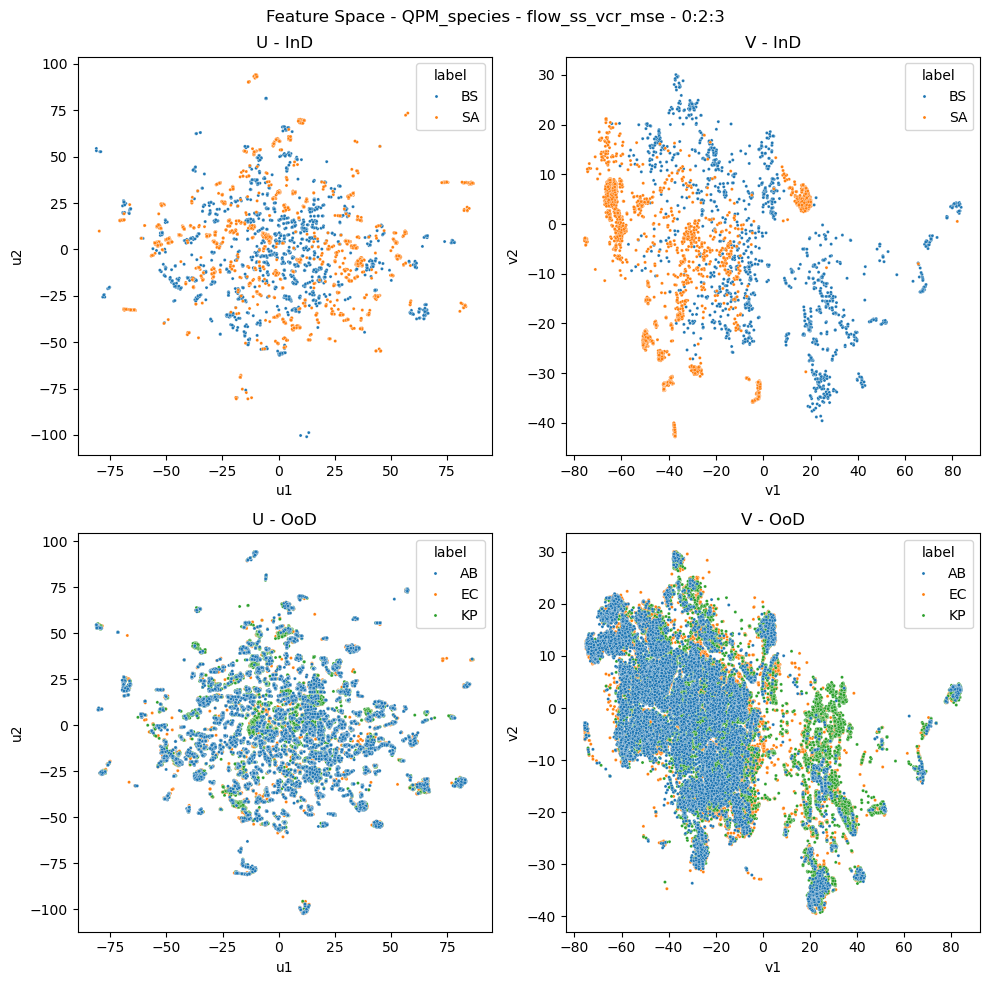

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
emb_data = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
emb_data = pd.concat([emb_data, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    emb_data = pd.concat([emb_data, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")

sns.scatterplot(data=emb_data[(emb_data['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=emb_data[(emb_data['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=emb_data[(emb_data['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=emb_data[(emb_data['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)

plt.tight_layout()
plt.show()

  0%|                                                                                                                                               | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████▊                                                                                                     | 1/4 [00:01<00:05,  1.91s/it]

 50%|███████████████████████████████████████████████████████████████████▌                                                                   | 2/4 [00:03<00:03,  1.93s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 3/4 [00:05<00:01,  1.98s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.09s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.04s/it]

  0%|                                                                                                                                               | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████▊                                                                                                     | 1/4 [00:11<00:34, 11.40s/it]

 50%|███████████████████████████████████████████████████████████████████▌                                                                   | 2/4 [00:22<00:22, 11.43s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 3/4 [00:34<00:11, 11.51s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:46<00:00, 11.71s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:46<00:00, 11.62s/it]

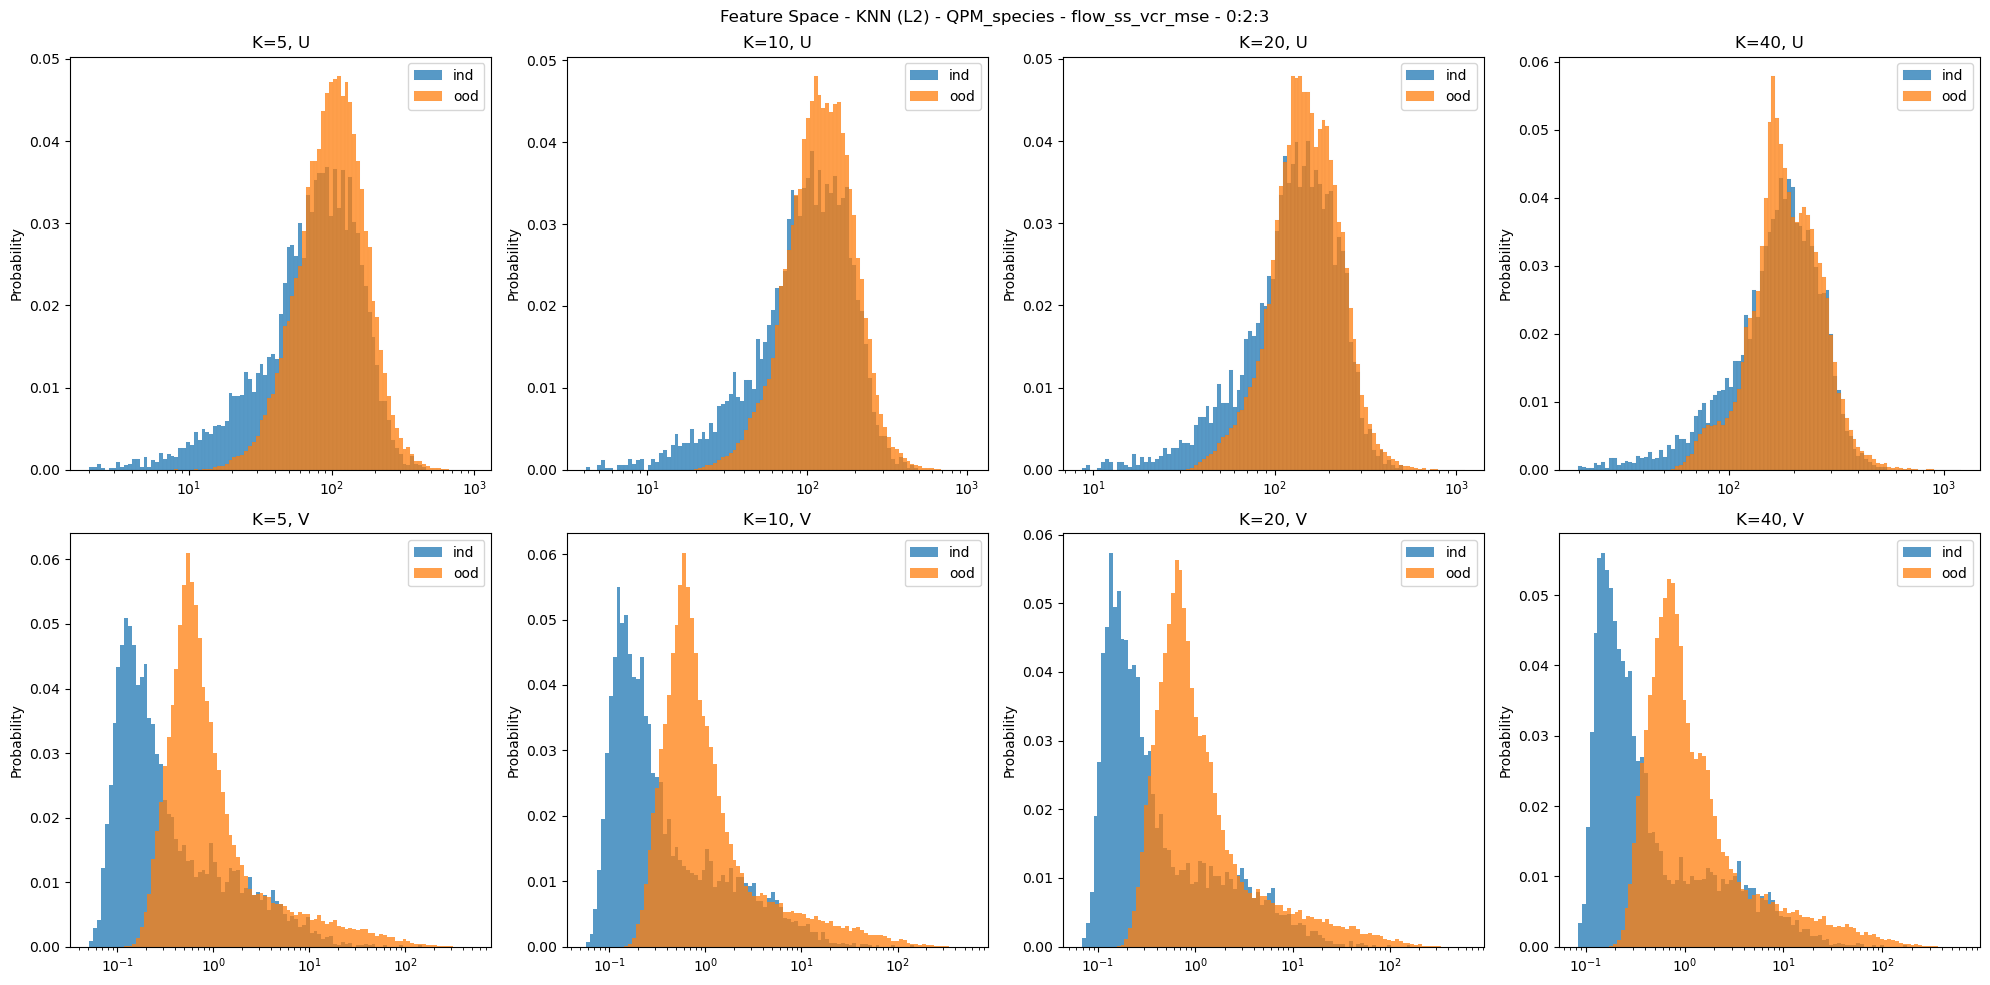

In [14]:
import faiss

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

index_e_u = faiss.IndexFlatL2(ind_e_u.shape[-1])
index_e_u.add(ind_e_u)
for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_e_u.search(ind_e_u, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_e_u.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index_e_v = faiss.IndexFlatL2(ind_e_v.shape[-1])
index_e_v.add(ind_e_v)
for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_e_v.search(ind_e_v, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_e_v.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                               | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████▊                                                                                                     | 1/4 [00:01<00:05,  1.86s/it]

 50%|███████████████████████████████████████████████████████████████████▌                                                                   | 2/4 [00:03<00:03,  1.89s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 3/4 [00:05<00:01,  1.94s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  2.04s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.99s/it]

  0%|                                                                                                                                               | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████▊                                                                                                     | 1/4 [00:11<00:33, 11.28s/it]

 50%|███████████████████████████████████████████████████████████████████▌                                                                   | 2/4 [00:22<00:22, 11.45s/it]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 3/4 [00:34<00:11, 11.44s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:45<00:00, 11.49s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:45<00:00, 11.46s/it]

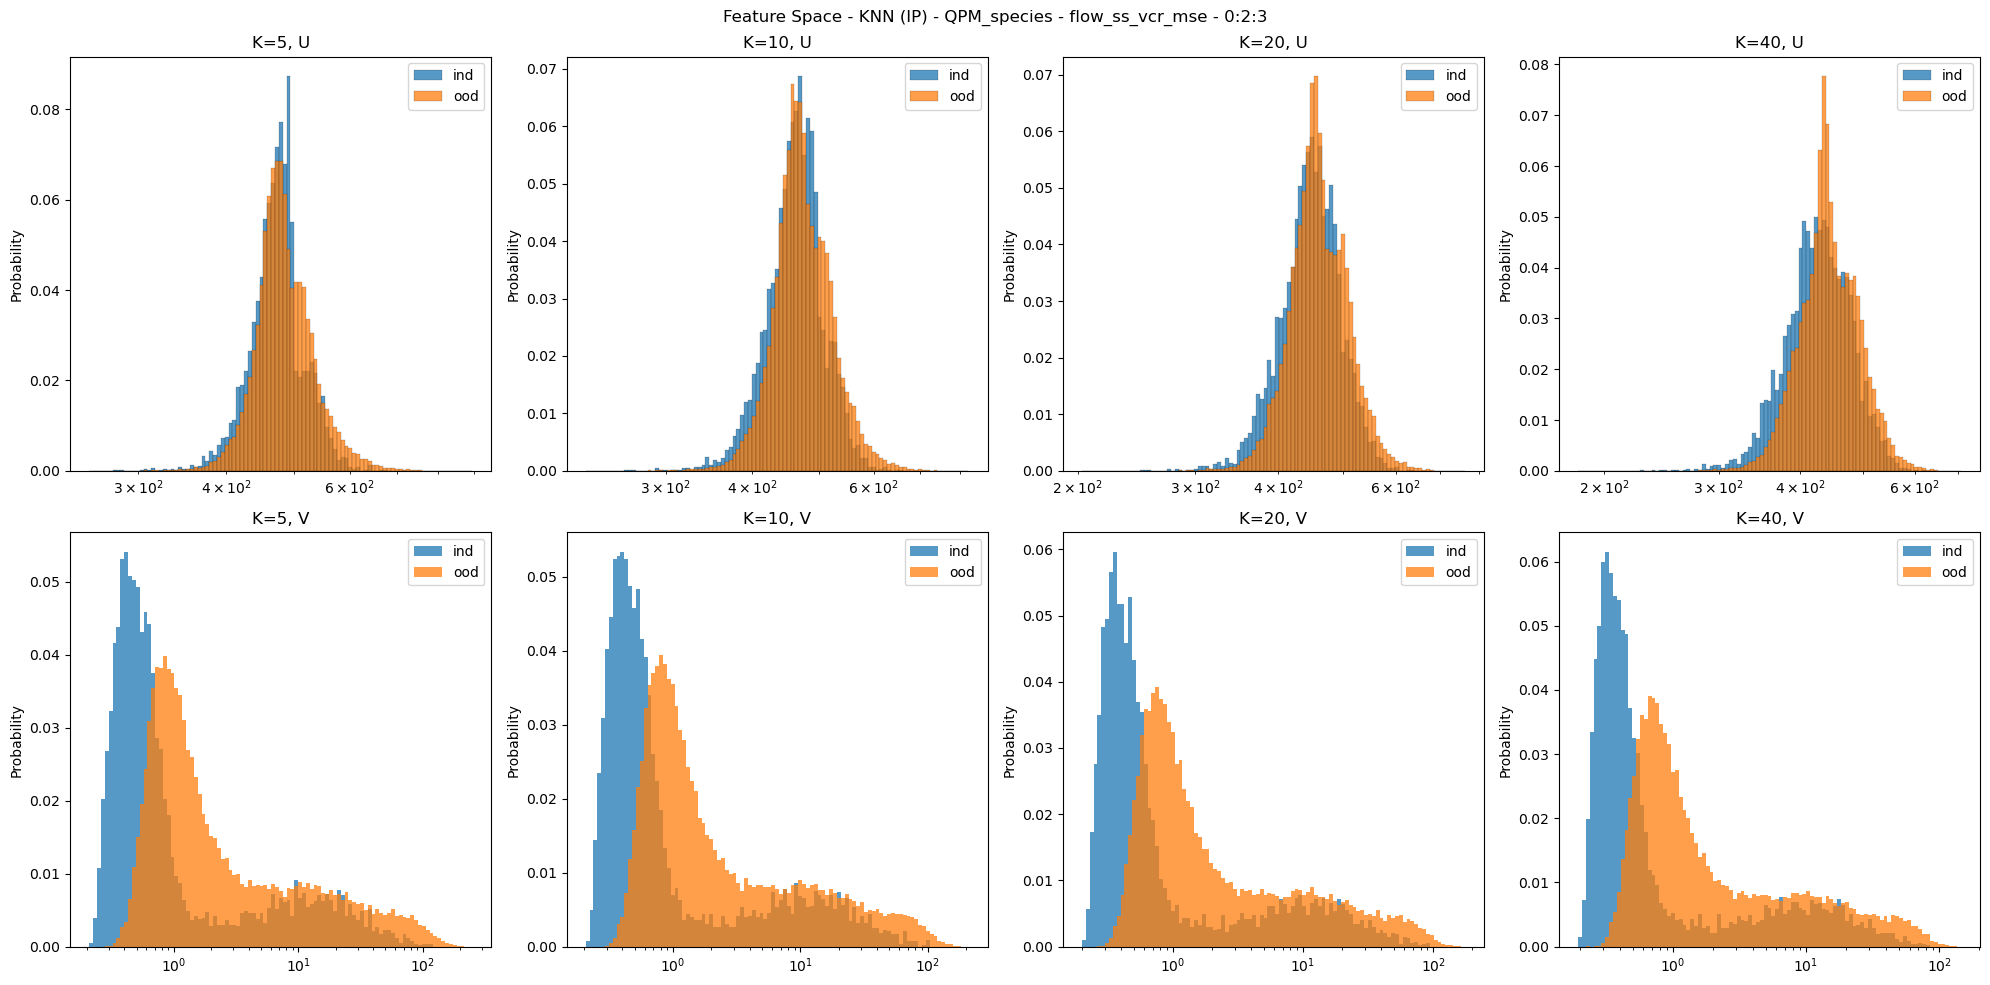

In [15]:
import faiss

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

index_e_u = faiss.IndexFlatIP(ind_e_u.shape[-1])
index_e_u.add(ind_e_u)
for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_e_u.search(ind_e_u, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_e_u.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index_e_v = faiss.IndexFlatIP(ind_e_v.shape[-1])
index_e_v.add(ind_e_v)
for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_e_v.search(ind_e_v, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_e_v.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

In [16]:
from scipy.linalg import norm

trn_n_u = norm(trn_e_u, axis=-1)
trn_n_v = norm(trn_e_v, axis=-1)
val_n_u = norm(val_e_u, axis=-1)
val_n_v = norm(val_e_v, axis=-1)
ind_n_u = norm(ind_e_u, axis=-1)
ind_n_v = norm(ind_e_v, axis=-1)
if ood_str:
    ood_n_u = norm(ood_e_u, axis=-1)
    ood_n_v = norm(ood_e_v, axis=-1)
rnd_n_u = norm(rnd_e_u, axis=-1)
rnd_n_v = norm(rnd_e_v, axis=-1)

print(trn_n_u.mean(), trn_n_u.std(), trn_n_v.mean(), trn_n_v.std())
print(val_n_u.mean(), val_n_u.std(), val_n_v.mean(), val_n_v.std())
print(ind_n_u.mean(), ind_n_u.std(), ind_n_v.mean(), ind_n_v.std())
if ood_str:
    print(ood_n_u.mean(), ood_n_u.std(), ood_n_v.mean(), ood_n_v.std())
print(rnd_n_u.mean(), rnd_n_u.std(), rnd_n_v.mean(), rnd_n_v.std())

22.743057 0.764997 1.258139 1.3692687
22.68419 0.6822891 1.146279 1.2093446
22.750011 0.755175 1.2786461 1.36756
23.255352 1.2497352 2.0060554 2.2396302
34.55469 0.91705245 58.1164 0.75561714


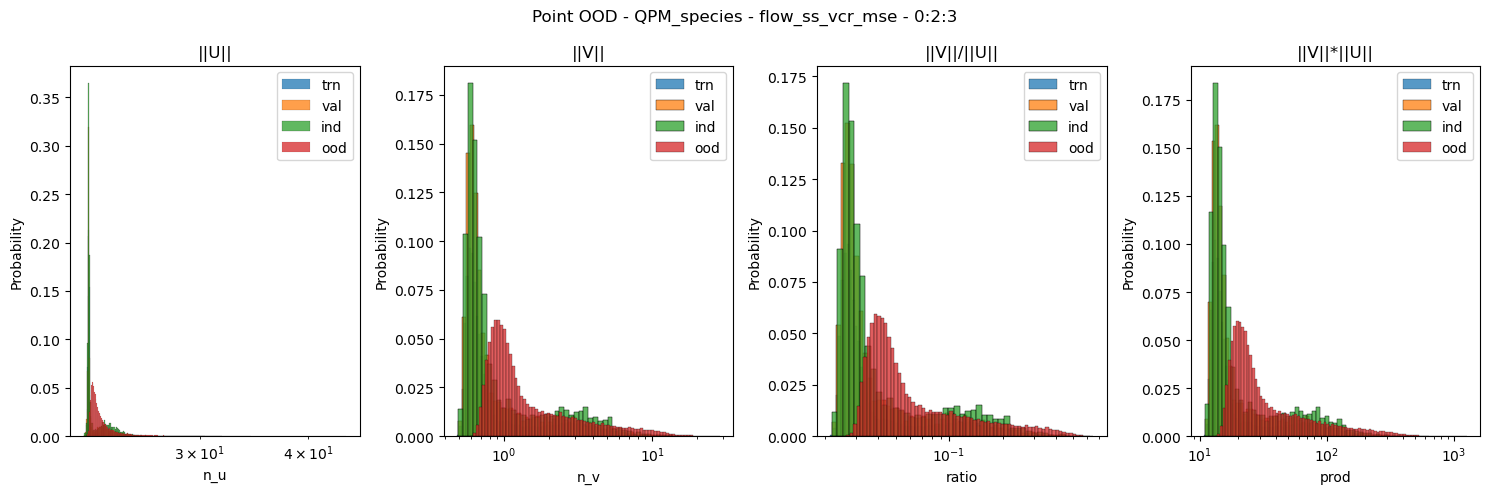

In [17]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))
df_rnd = pd.DataFrame(dict(n_u=rnd_n_u, n_v=rnd_n_v, ratio=rnd_n_v/rnd_n_u, prod=rnd_n_v*rnd_n_u))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    # sns.histplot(data=df_rnd, x=prop, log_scale=True, fill=True, label='rnd', stat='density', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [18]:
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


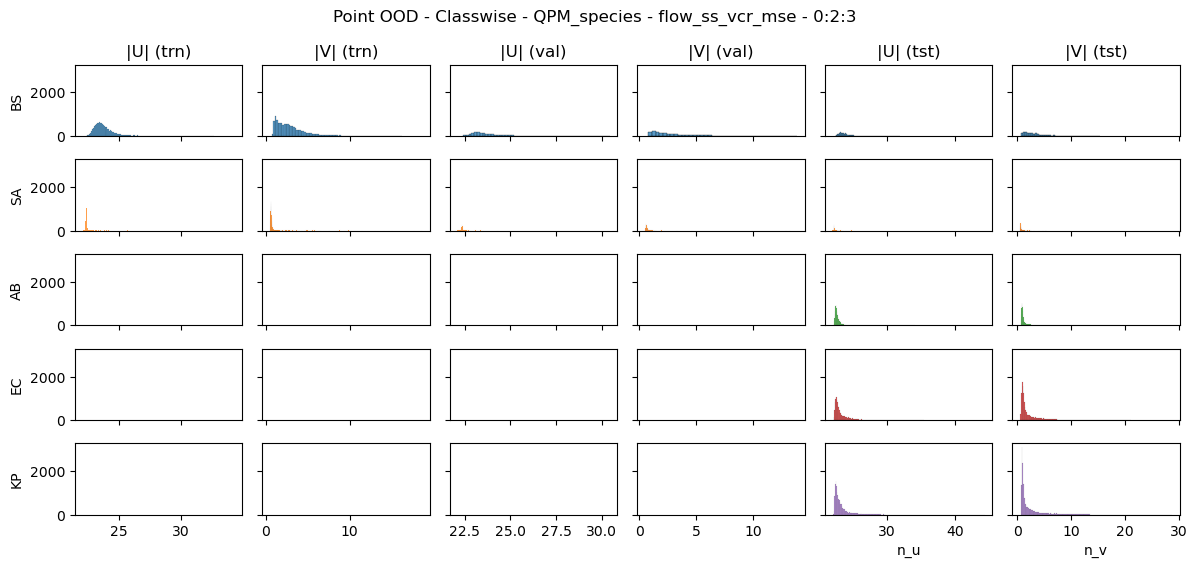

In [19]:
# pointwise
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='all')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

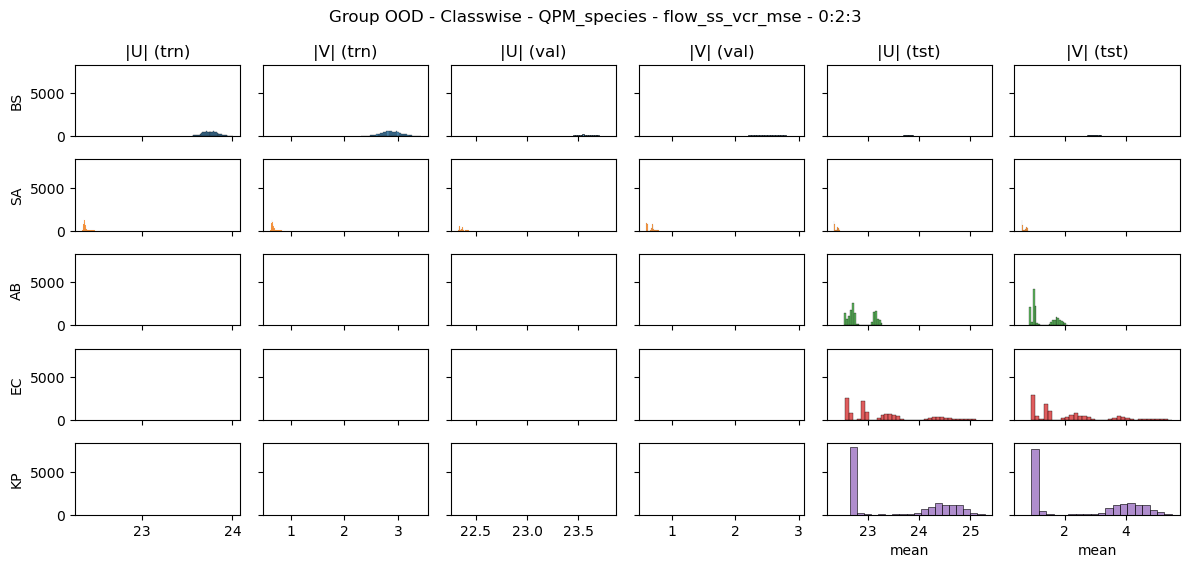

In [20]:
# groupwise
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='all')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()